In [42]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [43]:
df = pd.read_excel("Timeseries.xlsx")


In [44]:
df.head()

,Product_Name,Day,Dollar,Discount_Type,Sales
0,Product,2018-09-16,6.3566,No Discount,11377.23
1,Product,2018-09-15,6.3566,No Discount,7188.99
2,Product,2018-09-14,6.3566,No Discount,5335.78
3,Product,2018-09-13,6.3945,No Discount,6453.03
4,Product,2018-09-12,6.4538,INSERT,7881.13


In [45]:
df['Day'].min(), df['Day'].max()

(Timestamp('2015-07-06 00:00:00'), Timestamp('2018-09-16 00:00:00'))

In [46]:
df =pd.get_dummies(df)

In [47]:
df = df.set_index("Day")
df.index

DatetimeIndex(['2018-09-16', '2018-09-15', '2018-09-14', '2018-09-13',
               '2018-09-12', '2018-09-11', '2018-09-10', '2018-09-09',
               '2018-09-08', '2018-09-07',
               ...
               '2015-07-15', '2015-07-14', '2015-07-13', '2015-07-12',
               '2015-07-11', '2015-07-10', '2015-07-09', '2015-07-08',
               '2015-07-07', '2015-07-06'],
              dtype='datetime64[ns]', name='Day', length=1169, freq=None)

In [48]:
ma= df['Sales'].resample('MS').mean()

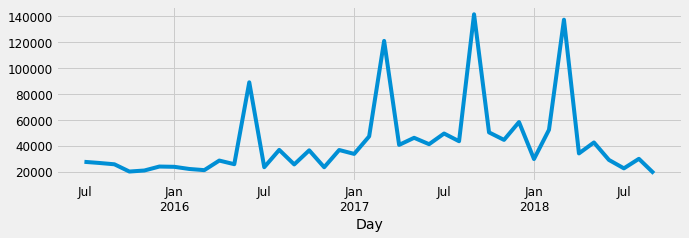

In [49]:
ma.plot(figsize=(10, 3))
plt.show()

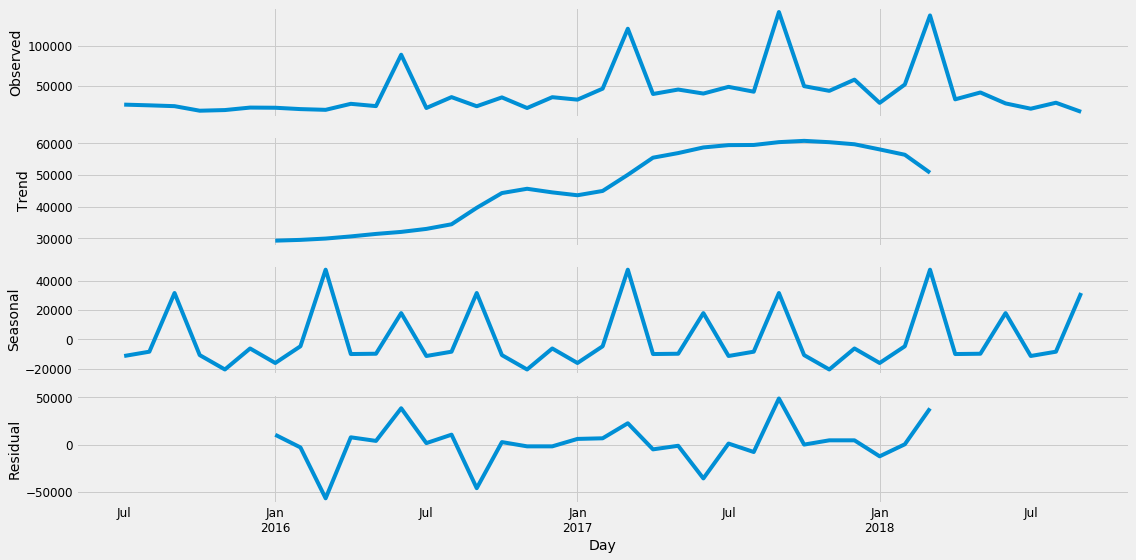

In [50]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
decomposition = sm.tsa.seasonal_decompose(ma, model='additive')
fig = decomposition.plot()
plt.show()

Time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [58]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))



Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [59]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(Aylık_ortalama,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            
            continue

In [60]:
mod = sm.tsa.statespace.SARIMAX(ma,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1454      0.881     -0.165      0.869      -1.873       1.582
ma.L1         -0.6193      0.555     -1.117      0.264      -1.706       0.468
ar.S.L12      -0.4536      0.243     -1.867      0.062      -0.930       0.023
sigma2      1.914e+09   2.38e-10   8.04e+18      0.000    1.91e+09    1.91e+09


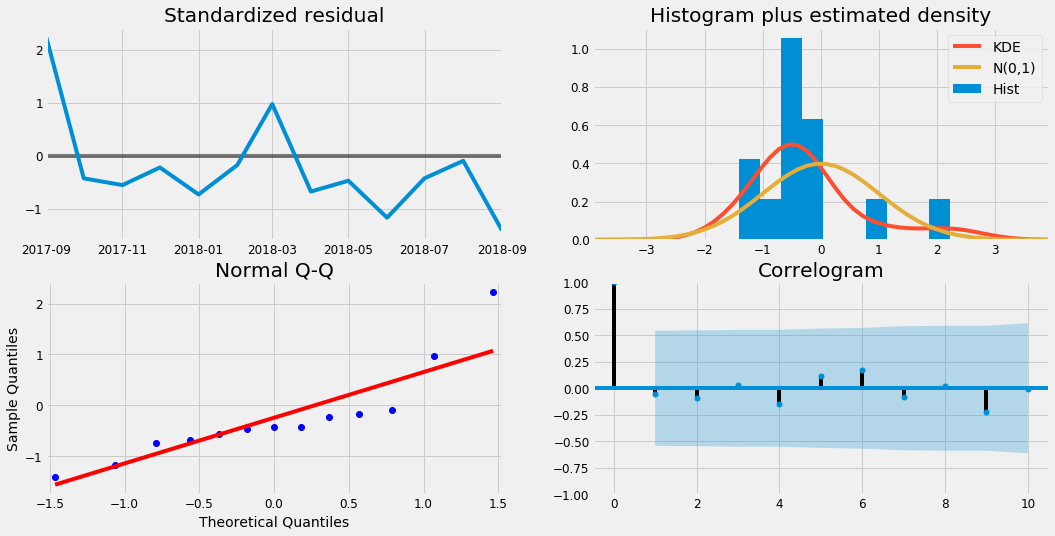

In [61]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

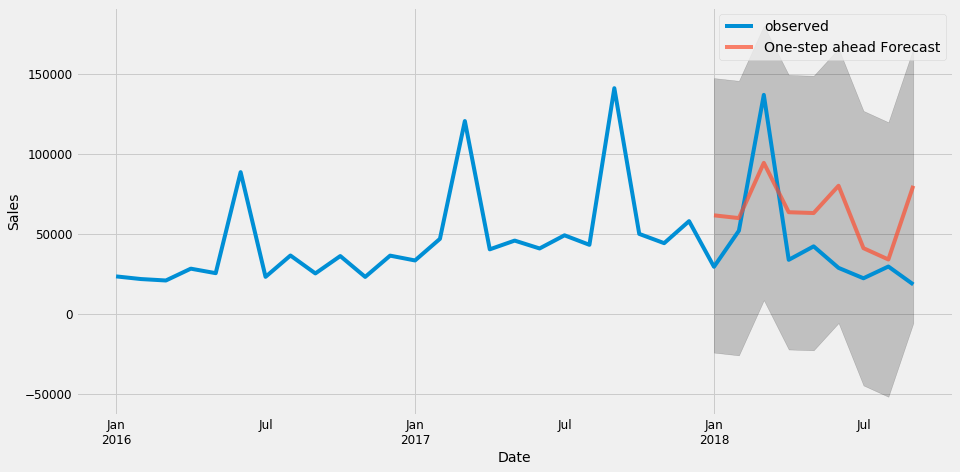

In [62]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ma['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()